In [1]:
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
from astropy.table import Table, vstack
from scipy.special import gammaincinv, gamma
from sklearn.neighbors import KDTree

plt.style.use('../notebooks/jpg.mplstyle')

labels = dict(
    m_g = r'$m_g$',
    m_r = r'$m_r$',
    m_i = r'$m_i$',
    mu_0_g_n1 = r'$\mu_0(g, n=1)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    mu_e_ave_g = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    mu_e_ave_r = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    mu_e_ave_i = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    r_e = r'$r_\mathrm{eff}$ [arcsec]',
    ell = 'Ellipticity'
)

In [2]:
def ra_dec_to_xyz(ra, dec):
    """
    Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
        RA and DEC in degrees.
    Returns
    -------
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra*np.pi/180.)
    cos_ra = np.cos(ra*np.pi/180.)

    sin_dec = np.sin(np.pi/2-dec*np.pi/180.)
    cos_dec = np.cos(np.pi/2-dec*np.pi/180.)

    return (cos_ra*sin_dec, sin_ra*sin_dec, cos_dec)


def angular_dist_to_euclidean_dist(theta, r=1):
    """
    Convert angular distances to Euclidean distances.
    Parameters
    ----------
    theta : float or ndarray
        Angular distance.
    r : float, optional
        Radius. Unit sphere assumed as default.
    Returns
    -------
    d : float or ndarray
        Euclidean distance
    """
    d = 2*r*np.sin(0.5*theta*np.pi/180.)
    return d


def euclidean_dist_to_angular_dist(d, r=1):
    """
    Convert Euclidean distances to angular distances.
    Parameters
    ----------
    d : float or ndarray
        Euclidean distance
    r : float, optional
        Radius. Unit sphere assumed as default.
    Returns
    -------
    theta : float or ndarray
        Angular distance.
    """
    theta = 2*np.arcsin(d/r/2.)*180./np.pi
    return theta

In [3]:
data_path = '/Users/jgreco/local-io/hugs-data'
synth_path = os.path.join(data_path, 'synth-results')
fig_dir = '/Users/jgreco/local-io/figures/hugs-ana'
fig_label = 'blue-synths'

num_runs = 3

galcolors = ['blues', 'med', 'reds']
#galcolors = ['blues']
#galcolors = ['reds']

# combine synth results
synth_cat = []
synth_match = []
hugs_match = []

data = lambda fn: Table.read(os.path.join(synth_path, fn))

for color in galcolors:
    for i in range(1, num_runs + 1):
        label = '-{}-0{}.csv'.format(color, i)
        synth_cat.append(data('synth-cat' + label))
        synth_match.append(data('synth-match' + label))
        hugs_match.append(data('hugs-match' + label))
        
synth_cat = vstack(synth_cat)
synth_match = vstack(synth_match)
hugs_match = vstack(hugs_match)

In [4]:
synth_cat_copy = synth_cat.copy()
synth_match_copy = synth_match.copy()
hugs_match_copy = hugs_match.copy()

In [255]:
synth_cat = synth_cat_copy.copy()
synth_match = synth_match_copy.copy()
hugs_match = hugs_match_copy.copy()

In [10]:
match_sc = SkyCoord(hugs_match['ra'], hugs_match['dec'], unit='deg')
idx, sep, _ = match_sc.match_to_catalog_sky(match_sc, 11)

cut = hugs_match['acorr_ratio'] < 1.85
cut &= (sep.arcmin > 1.0)

cut.sum()

949382

In [5]:
injected = synth_cat
recovered = synth_match
measured = hugs_match

x_par = 'r_e'
y_par = 'mu_e_ave_g'

dbin=[1.0, 0.5]
x_bin_pad=[1, 3]
y_bin_pad=[0, 3]

bins = [np.arange(np.floor(injected[x_par].min()) -\
                            x_bin_pad[0]*dbin[0],
                  np.ceil(injected[x_par].max()) +\
                          x_bin_pad[1]*dbin[0], dbin[0]),
        np.arange(np.floor(injected[y_par].min()) -\
                            y_bin_pad[0]*dbin[1],
                  np.ceil(injected[y_par].max()) +\
                          y_bin_pad[1]*dbin[1], dbin[1])]

x_centers = 0.5 * (bins[0][1:] + bins[0][:-1]) - 0.5*dbin[0]
y_centers = 0.5 * (bins[1][1:] + bins[1][:-1]) - 0.5*dbin[1]

In [6]:
H_injected, _, _ = np.histogram2d(injected[x_par],
                                  injected[y_par],
                                  bins=bins)
H_measured, _, _ = np.histogram2d(recovered[x_par],
                                  recovered[y_par],
                                  bins=bins)

H_injected[H_injected==0] = 1e-8
H_frac = H_measured/H_injected

r_e =  3": 50% complete @ mu_ave = 26.63; 25% complete @ mu_ave = 27.13
r_e =  4": 50% complete @ mu_ave = 26.96; 25% complete @ mu_ave = 27.34
r_e =  5": 50% complete @ mu_ave = 27.06; 25% complete @ mu_ave = 27.44
r_e =  6": 50% complete @ mu_ave = 27.13; 25% complete @ mu_ave = 27.56
r_e =  7": 50% complete @ mu_ave = 27.16; 25% complete @ mu_ave = 27.62
r_e =  8": 50% complete @ mu_ave = 27.16; 25% complete @ mu_ave = 27.63
r_e =  9": 50% complete @ mu_ave = 27.17; 25% complete @ mu_ave = 27.65
r_e = 10": 50% complete @ mu_ave = 27.17; 25% complete @ mu_ave = 27.66


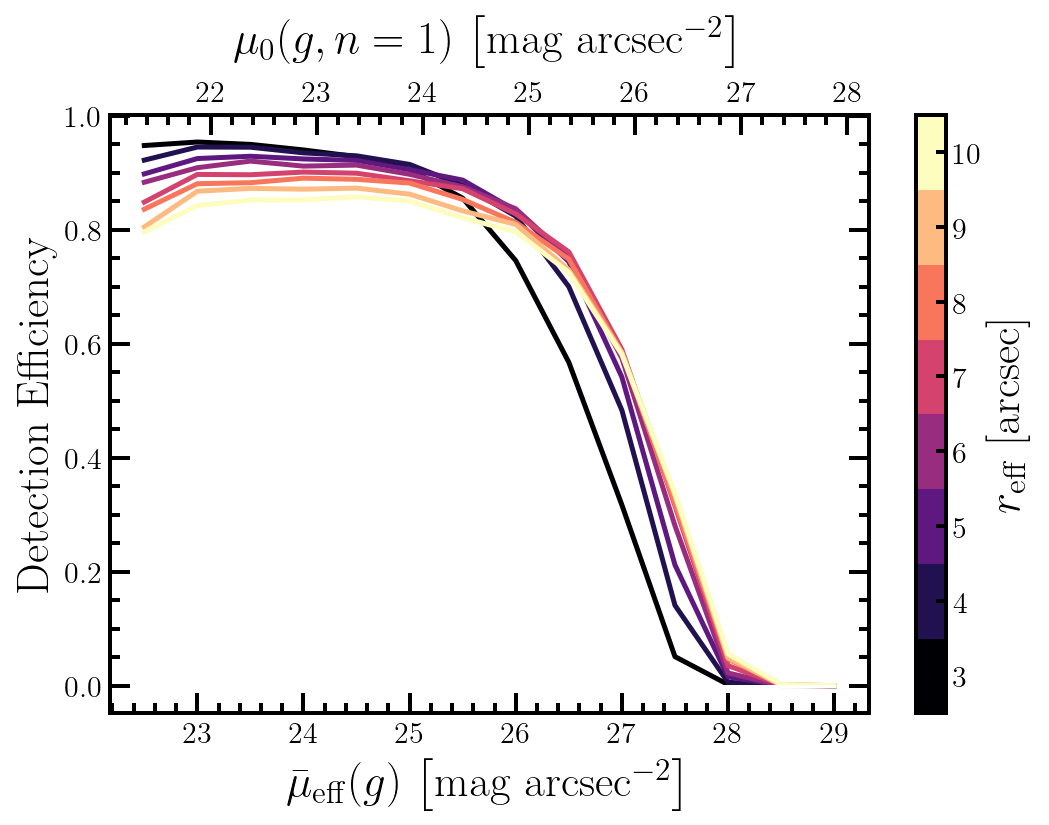

In [7]:
mu_vals = y_centers[1:-1]

colors = plt.cm.magma(np.linspace(0, 1, 9))

fig, ax = plt.subplots(figsize=(8.5, 5.5))

normalize = mcolors.Normalize(vmin=3, vmax=10)
colormap = plt.cm.magma

rad = x_centers[1:9]

for i in range(1, 9):
    color = colormap(normalize(x_centers[i]))
    ax.plot(mu_vals, H_frac[i, 1:-1], c=color, lw=2.5);
    
    eta = interp1d(H_frac[i, 1:-1], mu_vals)
    
    print('r_e = {:2.0f}": 50% complete @ mu_ave = {:.2f}; 25% complete @ mu_ave = {:.2f}'.\
          format(x_centers[i], eta(0.5), eta(0.25)))

ax.minorticks_on()

n = 1.0
b_n = gammaincinv(2. * n, 0.5)
f_n = gamma(2*n)*n*np.exp(b_n)/b_n**(2*n)
mu_0 = mu_vals + 2.5*np.log10(f_n) - 2.5*b_n/np.log(10)

ax2 = ax.twiny()
vals = [0] * len(mu_vals)
ax2.plot(mu_0, vals, c='w')
ax2.minorticks_on()


fs = 22.5

ax2.set_xlabel(labels['mu_0_g_n1'], fontsize=fs, labelpad=10);


ax.set_xlabel(labels['mu_e_ave_g'], fontsize=fs);

ax.set_ylabel('Detection Efficiency', fontsize=fs)

# Colorbar setup

colorparams = x_centers[1:9]
s_map = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(colorparams)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (colorparams[1] - colorparams[0])/2.0
boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

# Use this to emphasize the discrete color values
cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

cbar.ax.tick_params(length=5)
cbar.ax.set_ylabel(labels['r_e'], fontsize=fs);

fig.savefig('/Users/jgreco/local-io/figures/hugs-ana/completeness-1d-new-accor-cuts.png', dpi=200)

In [189]:
sky_meas = Table.read(os.path.join(data_path, 's18a_wide_skyobject_meas.fits'))
sky_force = Table.read(os.path.join(data_path, 's18a_wide_skyobject_force.fits'))

In [8]:
sky_mu = -48.6 - 2.5 * np.log10(sky_meas['g_apertureflux_84_flux'] / (np.pi * (8.2/2)**2))

/Users/jgreco/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [9]:
sky_radec = SkyCoord(sky_meas['g_ra'], sky_meas['g_dec'], unit='deg')

In [10]:
radius = 42 * 0.168 / 2
hugs_match_mu = hugs_match['mag_ap8_g'] + 2.5 * np.log10(np.pi * radius**2)

(20, 30)

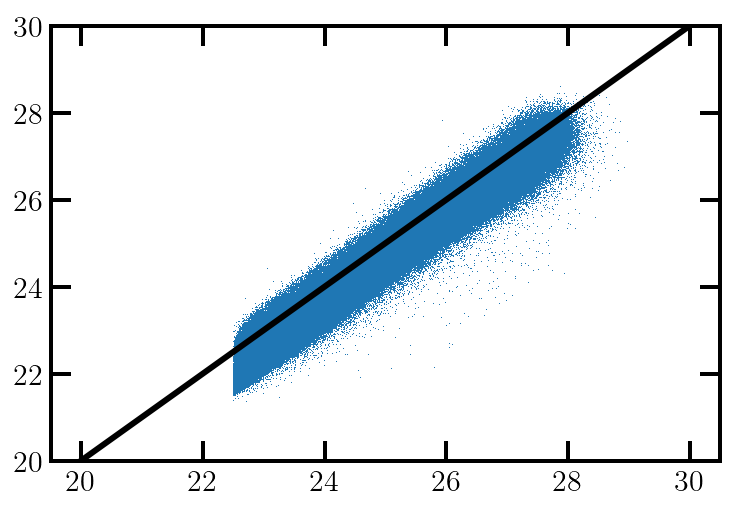

In [11]:
plt.plot(hugs_match['mu_ave_g'], hugs_match_mu, ',');
plt.plot([20, 30], [20, 30], 'k-', lw=3)
plt.ylim(20, 30)

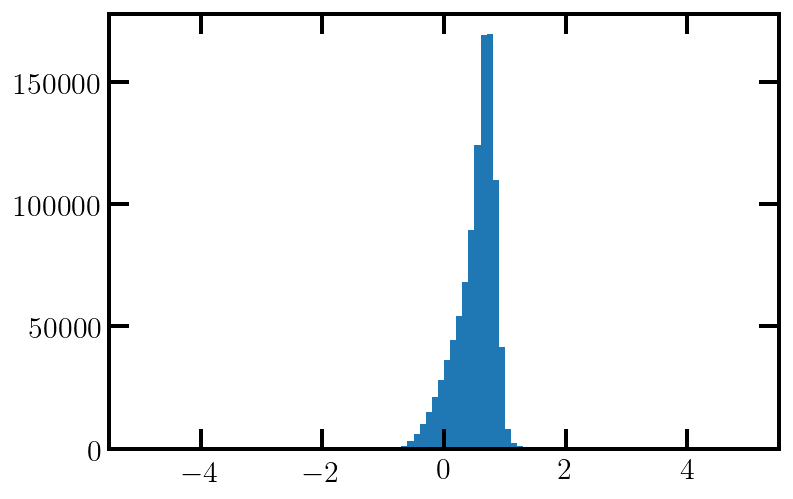

In [12]:
plt.hist(hugs_match['mu_ave_g'] - hugs_match_mu, bins=100, range=[-5, 5]);

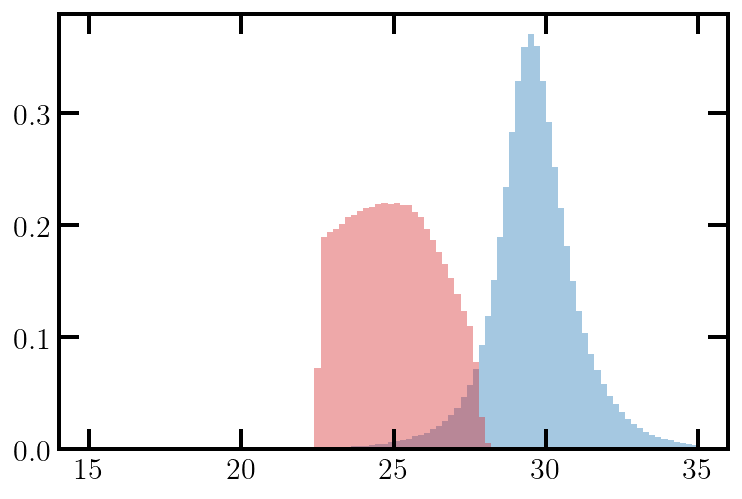

In [13]:
plt.hist(sky_mu, bins=100, density=True, alpha=0.4, color='tab:blue', range=(15, 35))
plt.hist(hugs_match['mu_ave_g'], bins=100, density=True, alpha=0.4, range=(15, 35), color='tab:red');

In [16]:
xyz = ra_dec_to_xyz(sky_meas['g_ra'], sky_meas['g_dec'])
kdt = KDTree(np.asarray(xyz).T)



In [237]:
hugs_cat = Table.read('/Users/jgreco/viz-basedir/hugs-s18a-02-vizinspect.csv')

In [81]:
synth_diffs = []

hugs_match_mu = hugs_match['mu_ave_g']

r = np.minimum(10 * hugs_match['flux_radius_ave_g'], np.ones(len(hugs_match)) * 10*25)
hugs_xyz = np.asarray(ra_dec_to_xyz(hugs_match['ra'], hugs_match['dec'])).T
idx = kdt.query_radius(hugs_xyz, angular_dist_to_euclidean_dist(r / 3600.0))

for i in range(len(hugs_match_mu)):

    synth_diffs.append(sky_mu[idx[i]].mean() - hugs_match_mu[i])
    
synth_diffs = np.array(synth_diffs)

print('complete')

hugs_cat_mu = hugs_cat['mu_ave_g']
hugs_diffs = []

r = np.minimum(10 * hugs_cat['flux_radius_ave_g'], np.ones(len(hugs_cat)) * 10*25)
hugs_xyz = np.asarray(ra_dec_to_xyz(hugs_cat['ra'], hugs_cat['dec'])).T
idx = kdt.query_radius(hugs_xyz, angular_dist_to_euclidean_dist(r / 3600.0))


for i in range(len(hugs_cat_mu)):

    hugs_diffs.append(sky_mu[idx[i]].mean() - hugs_cat_mu[i])
    
hugs_diffs = np.array(hugs_diffs)


print('complete')

/Users/jgreco/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


complete
complete


/Users/jgreco/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Warning: converting a masked element to nan.


In [82]:
hugs_diffs = np.ma.array(hugs_diffs, mask=np.isnan(hugs_diffs))
synth_diffs = np.ma.array(synth_diffs, mask=np.isnan(synth_diffs))

/Users/jgreco/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jgreco/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


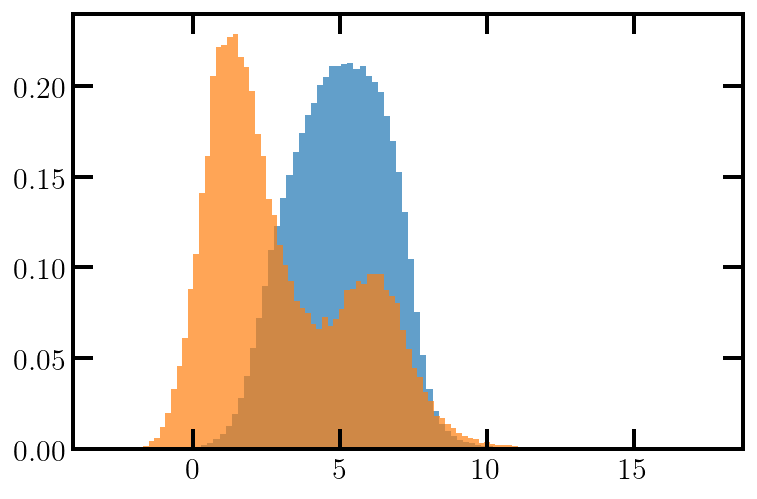

In [83]:
plt.hist(synth_diffs, bins=100, alpha=0.7, density=True)
plt.hist(hugs_diffs, bins=100, alpha=0.7, density=True);

In [102]:
dm = 1.65
mask = (synth_match_mu>26) & (synth_diffs.filled(1000) < dm)

mask.sum(), mask.sum() / (synth_match_mu>26).sum()

(9533, 0.032055549951242476)

In [103]:
(hugs_diffs.filled(1000) < 1.65).sum() , (hugs_diffs.filled(1000) < 1.65).sum()  / len(hugs_diffs)

(21223, 0.15495765186915889)

In [42]:
acorr_ratio
len(hugs_diffs)

136960

In [218]:
low_sb = hugs_match[hugs_match['mu_ave_g'] > 26]

acorr_cut = 1.85
print((hugs_cat['acorr_ratio'] > acorr_cut).sum())
print((hugs_match['acorr_ratio'] > acorr_cut).sum() / len(hugs_match))
print((low_sb['acorr_ratio'] > acorr_cut).sum() / len(low_sb))

42818
0.009513377876467484
0.02552873630558322


In [274]:
idx, sep, _ = match_sc.match_to_catalog_sky(match_sc, 2)
print((sep.arcsec < 1).sum())

442


In [249]:
idx, sep, _ = cat_sc.match_to_catalog_sky(cat_sc, 11)

print(len(hugs_cat) -(hugs_cat['acorr_ratio'] > acorr_cut).sum())
len(hugs_cat) -((hugs_cat['acorr_ratio'] > acorr_cut) | (sep.arcmin < 1.0)).sum() 

94142


92432

In [277]:
hugs_cat = Table.read('/Users/jgreco/viz-basedir/hugs-s18a-02-vizinspect.csv')

print(len(hugs_cat))
acorr_cut = 1.85
cat_cut = hugs_cat['acorr_ratio'] < acorr_cut
print(cat_cut.sum())

cat_sc = SkyCoord(hugs_cat['ra'], hugs_cat['dec'], unit='deg')
idx, sep, _ = cat_sc.match_to_catalog_sky(cat_sc, 11)
cat_cut &= sep.arcmin > 1.0
cat_cut.sum()

136960
94142


92432

In [279]:
cat_sc = SkyCoord(hugs_cat['ra'], hugs_cat['dec'], unit='deg')
idx, sep, _ = cat_sc.match_to_catalog_sky(cat_sc, 11)
cat_cut = sep.arcmin < 1.0
cat_cut.sum()

2461

In [228]:
from astropy.coordinates import SkyCoord


In [238]:
match_sc = SkyCoord(hugs_match['ra'], hugs_match['dec'], unit='deg')
cat_sc = SkyCoord(hugs_cat['ra'], hugs_cat['dec'], unit='deg')

In [273]:
idx, sep, _ = cat_sc.match_to_catalog_sky(cat_sc, 2)
print((sep.arcsec < 0.8).sum())

5367


16

In [ ]:
[hugs_diffs.filled(1000) > 1.65]
\

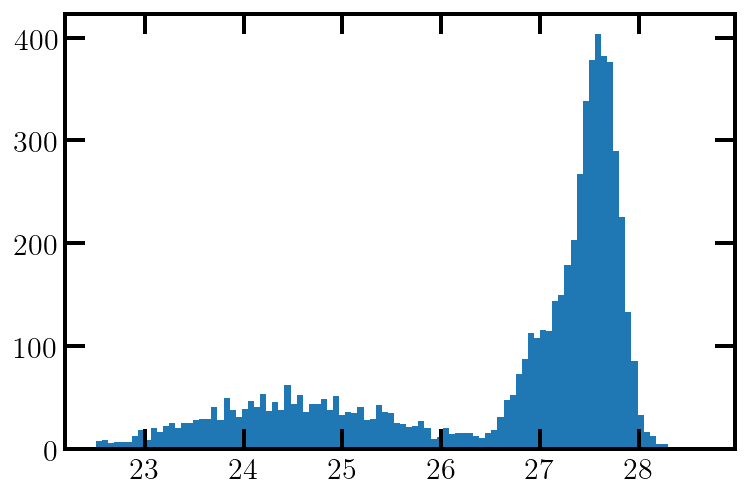

In [169]:
plt.hist(hugs_match[hugs_match['acorr_ratio'] > 2]['mu_ave_g'], bins=100);

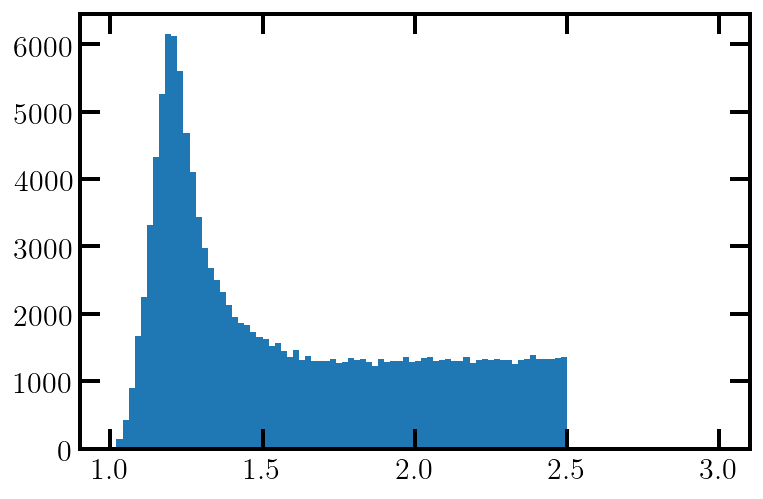

In [118]:
plt.hist(hugs_cat['acorr_ratio'], bins=100, range=(1, 3));

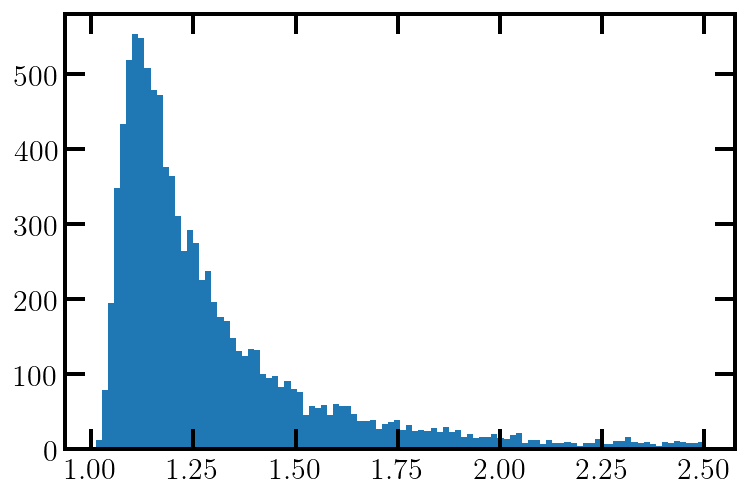

In [117]:
plt.hist(hugs_match[synth_diffs.filled(1000) < 1.65]['acorr_ratio'], bins=100);

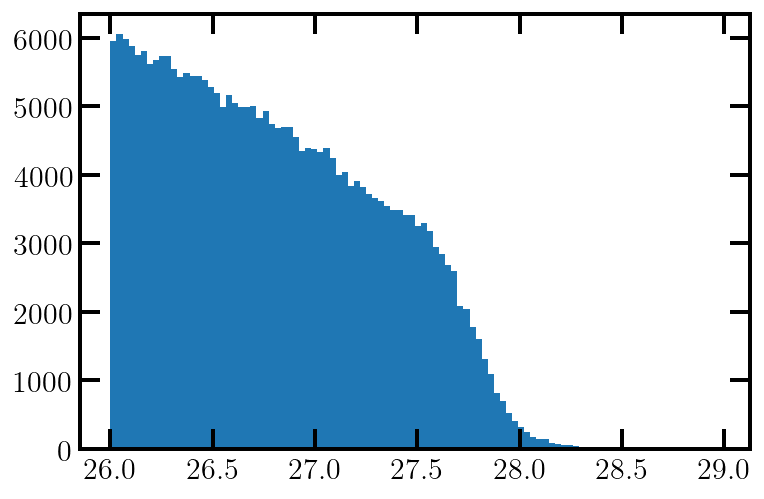

In [64]:
plt.hist(hugs_match_mu[hugs_match_mu>26], bins=100);